In [1]:
import os
import pickle
import copy
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import phate

In [2]:
import helpers

In [4]:
def load_data(admixtures_k, data_dir, admixture_dir):
    # Step -1: Load data
    merged_metadata, relatedness, genotypes_array, mapping_info = helpers.load_data()

    # Step 0: Pre-process data
    normalized_matrix, overlap_counts = helpers.preprocess_data_matrix(genotypes_array)

    # Fit PCA model on unrelated samples
    filters = ["filter_pca_outlier", "hard_filtered", "filter_contaminated"]
    _filtered_indices = merged_metadata[merged_metadata[filters].any(axis=1)].index
    filtered_indices = ~merged_metadata.index.isin(_filtered_indices)
    related_indices = ~merged_metadata['filter_king_related'].values

    to_fit_on = related_indices & filtered_indices
    to_transform_on = (~related_indices) & filtered_indices

    pca_emb, _ = helpers.compute_pca_from_hail(
        os.path.join(data_dir, 'pca_scores_hailcomputed.csv'),
        merged_metadata,
        50
    )

    admixture_ratios_list = []
    prefix = 'global'
    for n_comps in admixtures_k:
        fname = f"{prefix}.{n_comps}_metadata.tsv"
        admix_ratios = pd.read_csv(os.path.join(admixture_dir, fname), sep='\t', header=None)

        admixture_ratios_nonzero = admix_ratios.loc[:, 1:n_comps].values
        admixture_ratios = np.zeros((pca_emb.shape[0], admixture_ratios_nonzero.shape[1]))

        index = to_fit_on | to_transform_on
        admixture_ratios[index] = admixture_ratios_nonzero
        admixture_ratios_list.append(admixture_ratios)

    return pca_emb, merged_metadata, to_fit_on, to_transform_on, admixture_ratios_list, mapping_info[1]

In [5]:
admixtures_k = [2, 3, 4, 5, 6, 7, 8, 9]
data_dir = '/lustre06/project/6065672/shared/MattDataSharing/1KGP+HGDP/V4'
admixture_dir = '/lustre06/project/6065672/shared/MattDataSharing/1KGP+HGDP/V4/admixture/ADMIXTURE_HGDP+1KGP'

pca_input, metadata, fit_idx, transform_idx, admixture_ratios_list, cmap = load_data(
    admixtures_k, data_dir, admixture_dir
)

Loading previously computed non-missing overlap matrix...


In [7]:
# Helper function to save/load objects
def save_pickle(obj, path):
    with open(path, 'wb') as f:
        pickle.dump(obj, f)

def load_pickle(path):
    with open(path, 'rb') as f:
        return pickle.load(f)

# Compute PHATE embeddings or load if available
def compute_or_load_phate(pca_input, fit_idx, transform_idx, ts, phate_dir, **phate_params):
    os.makedirs(phate_dir, exist_ok=True)
    param_str = "_".join([f"{k}_{v}" for k, v in phate_params.items()])
    file_path = os.path.join(phate_dir, f"phate_{param_str}.pkl")

    if os.path.exists(file_path):
        print(f"Loading PHATE operator from {file_path}")
        phate_operator = load_pickle(file_path)
    else:
        phate_operator = phate.PHATE(random_state=42, **phate_params)
        phate_operator.fit(pca_input[fit_idx])
        save_pickle(phate_operator, file_path)
        print(f"Saved PHATE operator to {file_path}")

    output_embs = []
    for t in ts:
        phate_operator.set_params(t=t)
        phate_emb = np.zeros((len(pca_input), 2))
        phate_emb[fit_idx] = phate_operator.transform(pca_input[fit_idx])
        phate_emb[transform_idx] = phate_operator.transform(pca_input[transform_idx])
        output_embs.append(phate_emb)

    return output_embs, phate_operator

In [26]:
# Compute PHATE embeddings
output_dir = 'results'
ts = [5, 10, 20, 50, 100]
knn = 100
decay = 60
gamma = 1


embeddings_list, phate_operator = compute_or_load_phate(
    pca_input,
    fit_idx,
    transform_idx,
    ts,
    output_dir,
    n_landmark=None,
    knn=knn,
    decay=decay,
    gamma=gamma
)

Running PHATE on 3400 observations and 50 variables.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculated KNN search in 0.77 seconds.
  Calculating affinities...
  Calculated affinities in 0.27 seconds.
Calculated graph and diffusion operator in 1.06 seconds.
Saved PHATE operator to results/phate_n_landmark_None_knn_100_decay_60_gamma_1.pkl
Calculating diffusion potential...
Calculated diffusion potential in 5.09 seconds.
Calculating metric MDS...
Calculated metric MDS in 16.94 seconds.
Calculating KNN search...
Calculated KNN search in 0.15 seconds.
Calculating affinities...


/lustre06/project/6065672/sciclun4/Envs/phate_env/lib/python3.11/site-packages/phate/phate.py:884: RuntimeWarning: Pre-fit PHATE should not be used to transform a new data matrix. Please fit PHATE to the new data by running 'fit' with the new data.
  warnings.warn(


Calculated affinities in 0.10 seconds.
Calculating diffusion potential...
Calculated diffusion potential in 6.71 seconds.
Calculating metric MDS...
Calculated metric MDS in 16.91 seconds.
Calculating KNN search...
Calculated KNN search in 0.15 seconds.
Calculating affinities...
Calculated affinities in 0.04 seconds.
Calculating diffusion potential...


/lustre06/project/6065672/sciclun4/Envs/phate_env/lib/python3.11/site-packages/phate/phate.py:884: RuntimeWarning: Pre-fit PHATE should not be used to transform a new data matrix. Please fit PHATE to the new data by running 'fit' with the new data.
  warnings.warn(


Calculated diffusion potential in 8.37 seconds.
Calculating metric MDS...
Calculated metric MDS in 16.91 seconds.
Calculating KNN search...
Calculated KNN search in 0.15 seconds.
Calculating affinities...


/lustre06/project/6065672/sciclun4/Envs/phate_env/lib/python3.11/site-packages/phate/phate.py:884: RuntimeWarning: Pre-fit PHATE should not be used to transform a new data matrix. Please fit PHATE to the new data by running 'fit' with the new data.
  warnings.warn(


Calculated affinities in 0.18 seconds.
Calculating diffusion potential...
Calculated diffusion potential in 11.69 seconds.
Calculating metric MDS...
Calculated metric MDS in 16.99 seconds.
Calculating KNN search...
Calculated KNN search in 0.15 seconds.
Calculating affinities...


/lustre06/project/6065672/sciclun4/Envs/phate_env/lib/python3.11/site-packages/phate/phate.py:884: RuntimeWarning: Pre-fit PHATE should not be used to transform a new data matrix. Please fit PHATE to the new data by running 'fit' with the new data.
  warnings.warn(


Calculated affinities in 0.17 seconds.
Calculating diffusion potential...
Calculated diffusion potential in 13.36 seconds.
Calculating metric MDS...
Calculated metric MDS in 16.96 seconds.
Calculating KNN search...
Calculated KNN search in 0.15 seconds.
Calculating affinities...


/lustre06/project/6065672/sciclun4/Envs/phate_env/lib/python3.11/site-packages/phate/phate.py:884: RuntimeWarning: Pre-fit PHATE should not be used to transform a new data matrix. Please fit PHATE to the new data by running 'fit' with the new data.
  warnings.warn(


Calculated affinities in 0.18 seconds.


In [27]:
phate_operator.diff_op.shape

(3400, 3400)

In [32]:
# Compute PHATE embeddings
output_dir = 'results'
ts = [5, 10, 20, 50, 100]
knn = 200
decay = 60
gamma = 1


embeddings_list2, phate_operator2 = compute_or_load_phate(
    pca_input,
    fit_idx,
    transform_idx,
    ts,
    output_dir,
    n_landmark=None,
    knn=knn,
    decay=decay,
    gamma=gamma
)

Running PHATE on 3400 observations and 50 variables.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculated KNN search in 1.21 seconds.
  Calculating affinities...
  Calculated affinities in 0.21 seconds.
Calculated graph and diffusion operator in 1.46 seconds.
Saved PHATE operator to results/phate_n_landmark_None_knn_200_decay_60_gamma_1.pkl
Calculating diffusion potential...
Calculated diffusion potential in 5.07 seconds.
Calculating metric MDS...
Calculated metric MDS in 16.89 seconds.
Calculating KNN search...


/lustre06/project/6065672/sciclun4/Envs/phate_env/lib/python3.11/site-packages/phate/phate.py:884: RuntimeWarning: Pre-fit PHATE should not be used to transform a new data matrix. Please fit PHATE to the new data by running 'fit' with the new data.
  warnings.warn(


Calculated KNN search in 0.24 seconds.
Calculating affinities...
Calculated affinities in 0.04 seconds.
Calculating diffusion potential...
Calculated diffusion potential in 6.73 seconds.
Calculating metric MDS...
Calculated metric MDS in 16.91 seconds.
Calculating KNN search...


/lustre06/project/6065672/sciclun4/Envs/phate_env/lib/python3.11/site-packages/phate/phate.py:884: RuntimeWarning: Pre-fit PHATE should not be used to transform a new data matrix. Please fit PHATE to the new data by running 'fit' with the new data.
  warnings.warn(


Calculated KNN search in 0.24 seconds.
Calculating affinities...
Calculated affinities in 0.04 seconds.
Calculating diffusion potential...
Calculated diffusion potential in 8.39 seconds.
Calculating metric MDS...
Calculated metric MDS in 16.92 seconds.
Calculating KNN search...


/lustre06/project/6065672/sciclun4/Envs/phate_env/lib/python3.11/site-packages/phate/phate.py:884: RuntimeWarning: Pre-fit PHATE should not be used to transform a new data matrix. Please fit PHATE to the new data by running 'fit' with the new data.
  warnings.warn(


Calculated KNN search in 0.24 seconds.
Calculating affinities...
Calculated affinities in 0.04 seconds.
Calculating diffusion potential...
Calculated diffusion potential in 11.71 seconds.
Calculating metric MDS...
Calculated metric MDS in 16.92 seconds.
Calculating KNN search...


/lustre06/project/6065672/sciclun4/Envs/phate_env/lib/python3.11/site-packages/phate/phate.py:884: RuntimeWarning: Pre-fit PHATE should not be used to transform a new data matrix. Please fit PHATE to the new data by running 'fit' with the new data.
  warnings.warn(


Calculated KNN search in 0.24 seconds.
Calculating affinities...
Calculated affinities in 0.04 seconds.
Calculating diffusion potential...
Calculated diffusion potential in 13.37 seconds.
Calculating metric MDS...
Calculated metric MDS in 16.93 seconds.
Calculating KNN search...


/lustre06/project/6065672/sciclun4/Envs/phate_env/lib/python3.11/site-packages/phate/phate.py:884: RuntimeWarning: Pre-fit PHATE should not be used to transform a new data matrix. Please fit PHATE to the new data by running 'fit' with the new data.
  warnings.warn(


Calculated KNN search in 0.24 seconds.
Calculating affinities...
Calculated affinities in 0.04 seconds.


In [33]:
phate_operator2.diff_op.shape

(3400, 3400)

In [34]:
fit_idx.sum()

3400

In [43]:
phate_operator.diff_op

array([[0.0068416 , 0.00684159, 0.00659124, ..., 0.        , 0.        ,
        0.        ],
       [0.00906239, 0.0090624 , 0.0090624 , ..., 0.        , 0.        ,
        0.        ],
       [0.01061103, 0.01101407, 0.01101407, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.01700796, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.01325931,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.02059687]])

In [36]:
import networkx as nx
A = phate_operator.diff_op - np.diag(phate_operator.diff_op)*np.eye(len(phate_operator.diff_op))
graph = nx.from_numpy_array(A) # put into networkx

In [37]:
graph

In [38]:
component_Sizes = np.sort(np.array([len(k) for k in nx.connected_components(graph)]))[::-1]

In [39]:
component_Sizes

array([3400])

In [40]:
graph

In [56]:
import numpy as np
from scipy.sparse.csgraph import laplacian
from scipy.sparse.linalg import eigsh
import matplotlib.pyplot as plt
import networkx as nx

# Symmetrized adjacency matrix (if not already)
A = (phate_operator.diff_op + phate_operator.diff_op.T) / 2

# Compute normalized Laplacian
L = laplacian(A, normed=True)

# Compute second smallest eigenvalue/vector
eigenvalues, eigenvectors = eigsh(L, k=2, which='SM')  # Smallest magnitude eigenvalues
fiedler_vector = eigenvectors[:, 1]  # Second smallest eigenvector

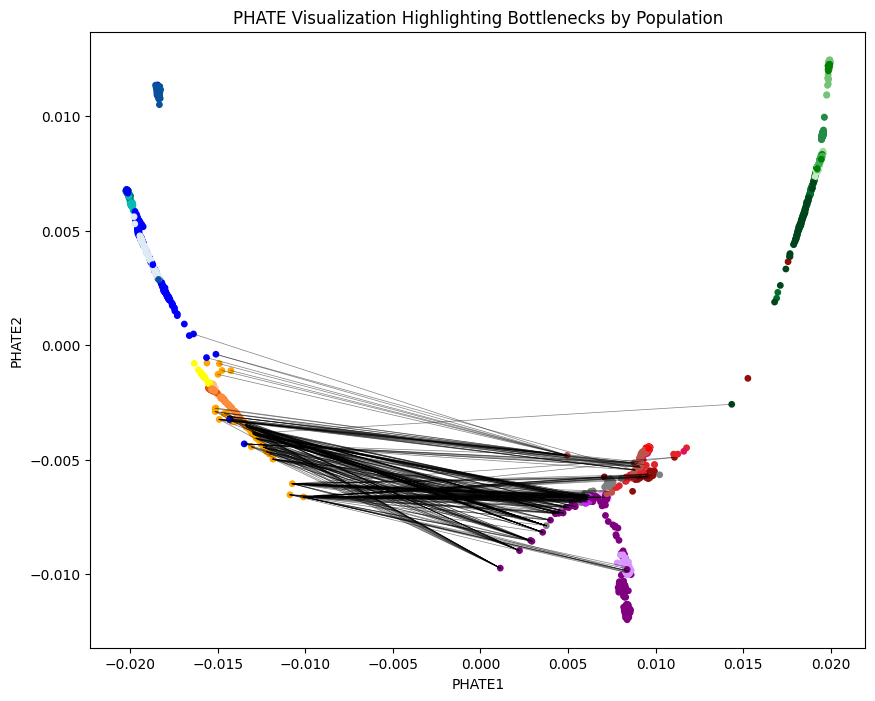

In [71]:
# PHATE embedding
phate_embedding = phate_operator.transform()

# Create a graph for edge visualization
graph = nx.from_numpy_array(A)

# Map population labels to colors using the colormap
node_colors = metadata['Population'][fit_idx].map(cmap)

# Identify bottleneck edges (optional)
threshold = np.percentile(np.abs(fiedler_vector), 95)  # Adjust threshold as needed
bottleneck_edges = [
    (u, v) for u, v in graph.edges
    if np.abs(fiedler_vector[u] - fiedler_vector[v]) > threshold
]

# Plot PHATE embedding with node colors
plt.figure(figsize=(10, 8))
sc = plt.scatter(
    phate_embedding[:, 0],
    phate_embedding[:, 1],
    c=node_colors,
    s=15
)

# Add bottleneck edges to the plot
for u, v in bottleneck_edges:
    plt.plot(
        [phate_embedding[u, 0], phate_embedding[v, 0]],
        [phate_embedding[u, 1], phate_embedding[v, 1]],
        color='black', alpha=0.5, linewidth=0.5
    )

plt.title("PHATE Visualization Highlighting Bottlenecks by Population")
plt.xlabel("PHATE1")
plt.ylabel("PHATE2")
plt.show()

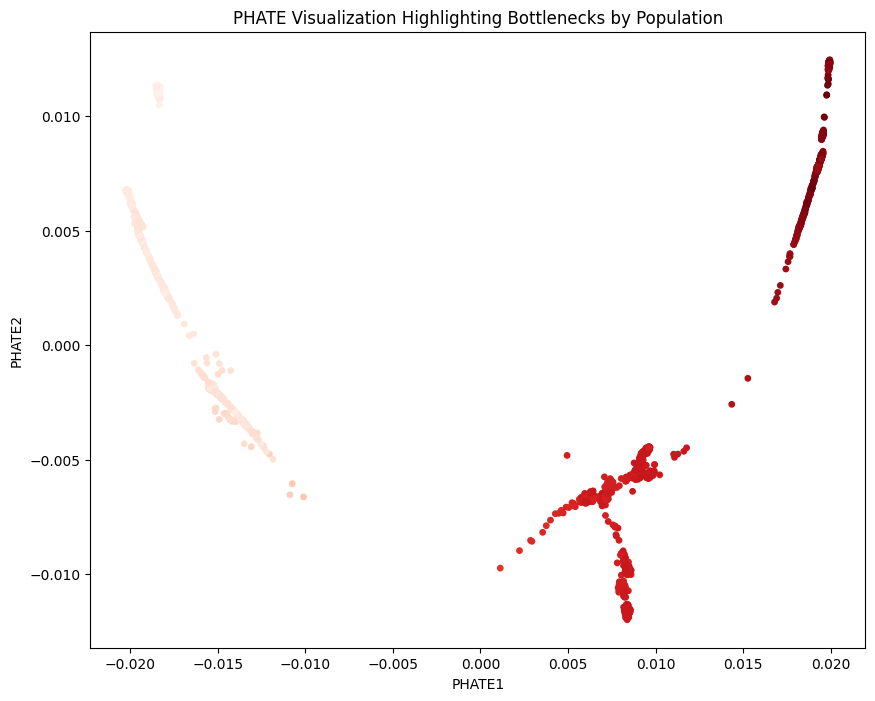

In [73]:
# PHATE embedding
phate_embedding = phate_operator.transform()

# Plot PHATE embedding with node colors
plt.figure(figsize=(10, 8))
sc = plt.scatter(
    phate_embedding[:, 0],
    phate_embedding[:, 1],
    c=fiedler_vector,
    cmap='Reds',
    s=15
)

plt.title("PHATE Visualization Fielder Vector")
plt.xlabel("PHATE1")
plt.ylabel("PHATE2")
plt.show()

In [75]:
# Calculate the second smallest eigenvalue (lambda_2)
lambda_2 = eigenvalues[1]

# Compute the Cheeger constant bounds
cheeger_lower_bound = lambda_2 / 2
cheeger_upper_bound = np.sqrt(2 * lambda_2)

# Print results
print(f"Second smallest eigenvalue (lambda_2): {lambda_2}")
print(f"Cheeger constant lower bound: {cheeger_lower_bound}")
print(f"Cheeger constant upper bound: {cheeger_upper_bound}")

# Approximation of the Cheeger constant
cheeger_approx = cheeger_lower_bound  # Or use lambda_2 directly
print(f"Approximated Cheeger constant: {cheeger_approx}")

Second smallest eigenvalue (lambda_2): 0.0003809914716391145
Cheeger constant lower bound: 0.00019049573581955725
Cheeger constant upper bound: 0.027604038532037824
Approximated Cheeger constant: 0.00019049573581955725
